In [2]:
# Changes to make: 
# Bring back outliers for delivery handover (at least 30 min) 
# Median hexagon handover instead of log 

# Problem Statement

NB: While this use case is loosely based on my work experience, I prepared mock data with the help of AI, and the approach is chosen based on this data.

#### Context: 
I work as a Data Analyst in a food delivery company. For smooth logistics we need to make sure our predictions are as accurate as possible: as we assign orders to couriers in real time, we need to estimate when each courier finishes their last delivery to make sure customer's waiting time is as low as possible. Currently we have a problem with estimating last leg of delivery, which is time period between courier's arrival to location and the moment when they press "delivered" (aka "Delivery Handover Time"). Let's assume that currently we simply estimate city's average for each order, we want to improve this estimate. 

#### Objective: 
Predict the Delivery Handover Time for each order based on order, courier, and delivery characteristics.

#### Type of Problem: 
Regression — the target variable delivery_handover_min is continuous.

##### Potential Modeling Steps:
Exploratory data analysis (EDA): Check distributions, correlations, and outliers, especially in delivery_handover_min.

Feature engineering: Extract weekday/month from orderday, encode categorical variables (vehicle_type).

Modeling: Linear regression, tree-based models (RandomForest, XGBoost), or ensemble methods.

Evaluation: Use metrics like RMSE, MAE, or R² to measure prediction accuracy.

## Data Preparation

In [3]:
# all imports are added here 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('mock_handover_data.csv')

In [5]:
df.head()

,orderday,delivery_deviation,avg_delivery_handover_min_same_location,vehicle_type,is_pooled,has_alcohol,is_new_courier,is_large_order,delivery_handover_min
0,2025-10-01,5.20,1.2965,BIKE,0,0,0,0,5.72
1,2025-11-11,3.78,1.4084,MOPED,1,0,1,0,3.92
2,2025-11-06,5.61,1.3208,CAR,0,0,1,0,9.24
3,2025-11-25,3.61,1.8592,CAR,1,0,1,0,7.80
4,2025-10-11,3.61,1.2687,BIKE,0,0,0,0,3.49


In [6]:
# !!! Replace later 
df['median_delivery_handover_min_same_location'] = np.expm1(df.avg_delivery_handover_min_same_location)
df['order_id'] = np.random.randint(100000, 999999, size=len(df))

In [7]:
# the data set was already cleaned up during its preparation but we want to make sure there are no nulls 
df.isnull().sum()

orderday                                      0
delivery_deviation                            0
avg_delivery_handover_min_same_location       0
vehicle_type                                  0
is_pooled                                     0
has_alcohol                                   0
is_new_courier                                0
is_large_order                                0
delivery_handover_min                         0
median_delivery_handover_min_same_location    0
order_id                                      0
dtype: int64

In [8]:
df.describe()

,delivery_deviation,avg_delivery_handover_min_same_location,is_pooled,has_alcohol,is_new_courier,is_large_order,delivery_handover_min,median_delivery_handover_min_same_location,order_id
count,8996.000000,8996.000000,8996.000000,8996.000000,8996.000000,8996.000000,8996.000000,8996.000000,8996.000000
mean,4.039787,1.491834,0.298133,0.041241,0.401067,0.090040,6.456719,3.646512,552264.364384
std,1.664204,0.297650,0.457463,0.198857,0.490142,0.286255,2.979277,1.415721,259247.451410
min,0.570000,0.343100,0.000000,0.000000,0.000000,0.000000,0.920000,0.409310,100187.000000
25%,2.770000,1.291675,0.000000,0.000000,0.000000,0.000000,4.170000,2.638877,327987.250000
50%,3.800000,1.490900,0.000000,0.000000,0.000000,0.000000,5.850000,3.441091,552326.000000
75%,5.080000,1.694750,1.000000,0.000000,1.000000,0.000000,8.180000,4.445284,778332.750000
max,10.220000,2.843700,1.000000,1.000000,1.000000,1.000000,14.990000,16.179211,999913.000000


##### Target Variable: 
delivery_handover_min: actual delivery handover time in mins per order, the value we want to predict

##### Numeric Variables: 
delivery_deviation: absolute deviation from ETA (expected time of arrival); we expect that high deviation causes longer handover (a customer does not expect the order)

median_delivery_handover_min_same_location: median handover time in the same customer location (using hexagons). If a customer orders to a tall building or office area we can expect higher handover time. We do not have a better metric unfortunately, so instead of using ID for each hexagon (which is computationally heavy) we can use a median as an estimate

##### Categotical Variable: 
vehicle_type: cars can take longer time to park; can be changed to a binary variable as well 

##### Binary Variables: 
is_pooled: a courier can have several orders in a bag. We expect that if there are still some orders in the bag a courier will hand over the order quicker. 

has_alcohol: a courier might need to validate ID

is_new_courier: it is more difficult for new couriers to find exact location or contact help desk or customer. 

is_large_order: large orders can take more time to deliver

## EDA

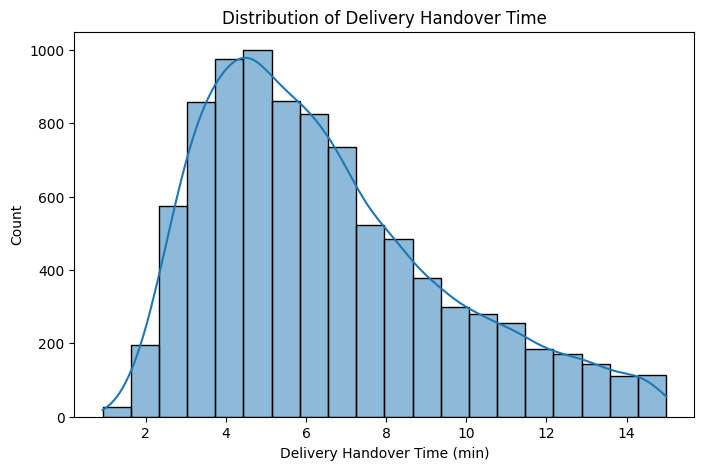

In [9]:
plt.figure(figsize=(8,5))
sns.histplot(df['delivery_handover_min'], kde=True, bins=20)
plt.title('Distribution of Delivery Handover Time')
plt.xlabel('Delivery Handover Time (min)')
plt.ylabel('Count')
plt.show()

# The metric is right-skewed, with outliers > 15 min obviously filtered out 
# Log transformation would be useful here 

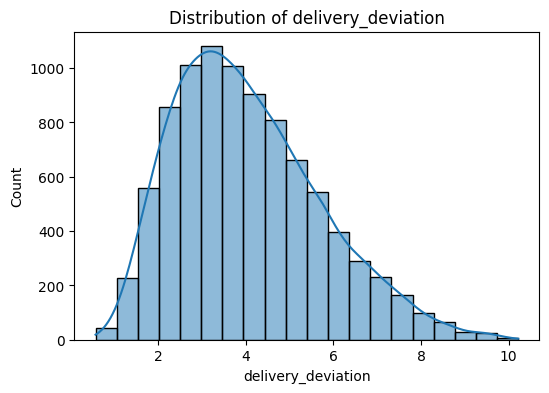

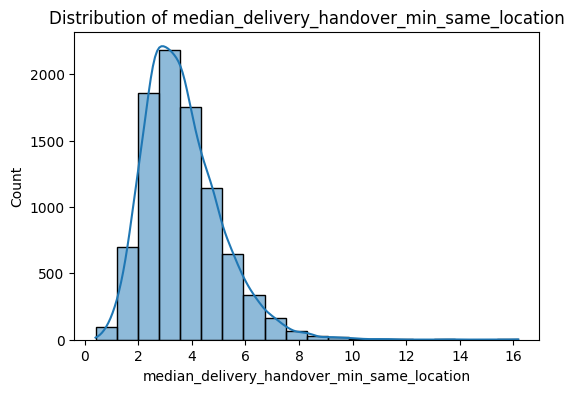

In [10]:
numeric_cols = ['delivery_deviation', 'median_delivery_handover_min_same_location']

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.show()

# both are right-skewed as well, log transformation might help a bit 

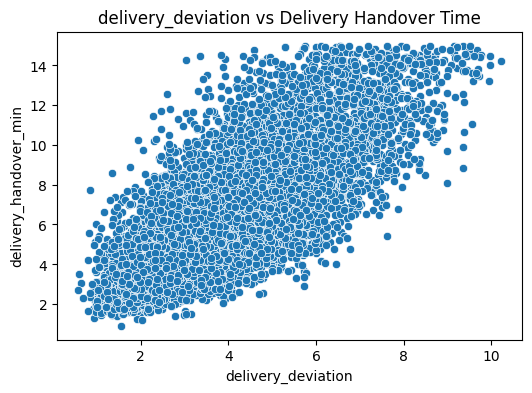

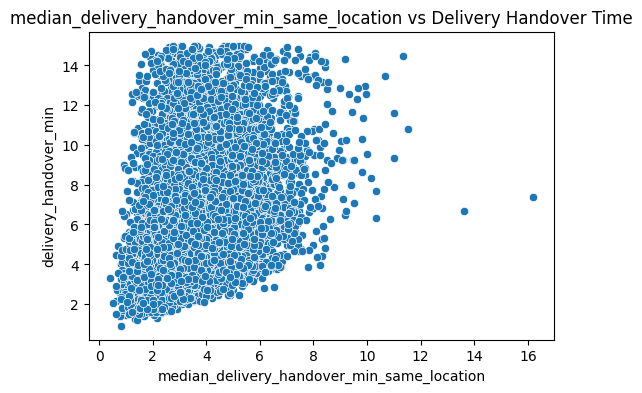

In [11]:
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[col], y=df['delivery_handover_min'])
    plt.title(f'{col} vs Delivery Handover Time')
    plt.show()

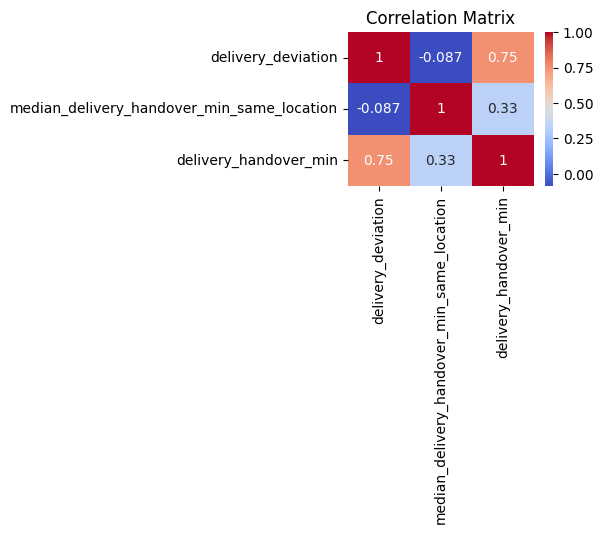

In [12]:
plt.figure(figsize=(3,2))
sns.heatmap(df[['delivery_deviation', 'median_delivery_handover_min_same_location', 'delivery_handover_min']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Delivery Deviation has surprisingly high correlation with Delivery Handover while Median Handover Time has none

In [13]:
categorical_cols = ['vehicle_type', 'is_pooled', 'has_alcohol', 'is_new_courier', 'is_large_order']

In [14]:
global_delivery_handover = df.delivery_handover_min.mean()
for c in categorical_cols:
    df_group = df.groupby(c).delivery_handover_min.agg(["mean", "count"])
    df_group["percent"] = (df_group["count"] / len(df)).round(4)*100
    df_group["diff"] = df_group["mean"] - global_delivery_handover
    df_group["risk"] = df_group["mean"] / global_delivery_handover
    display(df_group)

# vehicle type, alcohol and large order seem to make a difference 

,mean,count,percent,diff,risk
vehicle_type,,,,,
BIKE,5.923117,5576,61.98,-0.533602,0.917357
CAR,7.835234,2543,28.27,1.378515,1.213501
MOPED,5.852155,877,9.75,-0.604563,0.906367


,mean,count,percent,diff,risk
is_pooled,,,,,
0,6.475928,6314,70.19,0.019210,1.002975
1,6.411495,2682,29.81,-0.045223,0.992996


,mean,count,percent,diff,risk
has_alcohol,,,,,
0,6.382708,8625,95.88,-0.074010,0.988538
1,8.177305,371,4.12,1.720586,1.266480


,mean,count,percent,diff,risk
is_new_courier,,,,,
0,6.443653,5388,59.89,-0.013066,0.997976
1,6.476231,3608,40.11,0.019512,1.003022


,mean,count,percent,diff,risk
is_large_order,,,,,
0,6.362560,8186,91.0,-0.094158,0.985417
1,7.408296,810,9.0,0.951578,1.147378


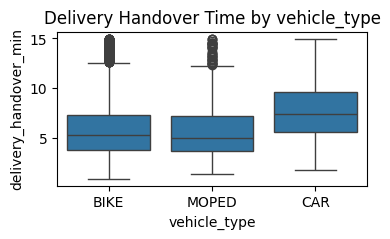

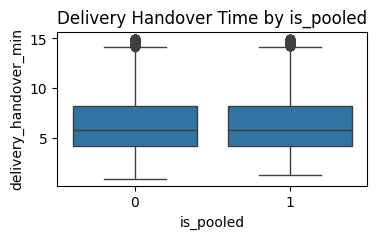

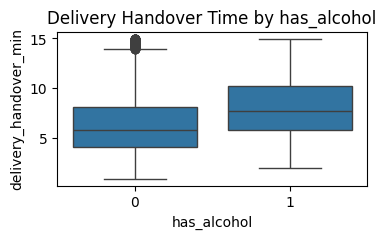

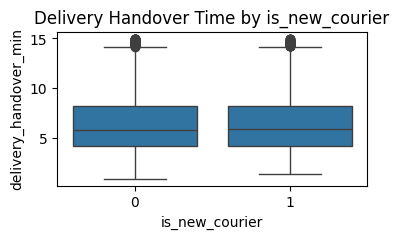

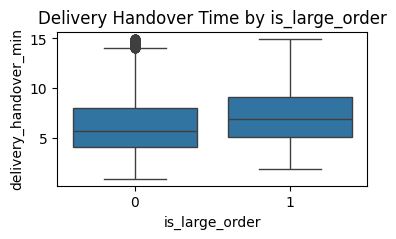

In [15]:
for col in categorical_cols:
    plt.figure(figsize=(4,2))
    sns.boxplot(x=df[col], y=df['delivery_handover_min'])
    plt.title(f'Delivery Handover Time by {col}')
    plt.show()

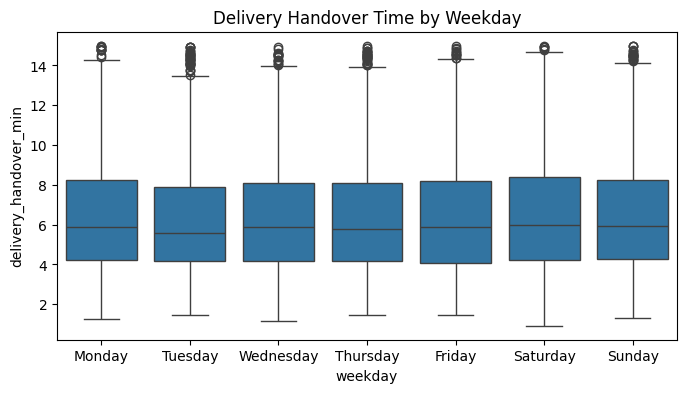

In [16]:
# Weekday check 

df['orderday'] = pd.to_datetime(df['orderday'])
df['weekday'] = df['orderday'].dt.day_name()

# Boxplot by weekday
plt.figure(figsize=(8,4))
sns.boxplot(x='weekday', y='delivery_handover_min', data=df, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Delivery Handover Time by Weekday')
plt.show()

# No visible difference 

## Model Training

In [ ]:
df.head()